# Motivation

    When using Convolution Neural Networks, feature extraction is not required, since it automatically extracts features in the convolution layer. This occurs by making use of a filter on the input image to produce a 2-dimensional feature map. 

# Load Data and Dependencies

In [126]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import logging

import tensorflow_datasets as tfds

In [127]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = 'D:\Image Classification Proj',
                        download=False,
                        shuffle_files=True)
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

In [128]:
## Check for GPU
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# CNN Baseline Model

In [3]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.2))

model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        3904      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        20752     
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 512)               75497984  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 75,523,666
Trainable params: 75,523,666
No

In [11]:
model.compile(loss = 'binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ['acc'])

In [12]:
model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 10)

Epoch 1/10
1639/1639 [==============================] - 50s 28ms/step - loss: 0.7476 - acc: 0.5053 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 2/10
1639/1639 [==============================] - 46s 28ms/step - loss: 0.6932 - acc: 0.5033 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 3/10
1639/1639 [==============================] - 46s 28ms/step - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 4/10
1639/1639 [==============================] - 46s 28ms/step - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 5/10
1639/1639 [==============================] - 46s 28ms/step - loss: 0.6932 - acc: 0.5033 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 6/10
1639/1639 [==============================] - 46s 28ms/step - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 7/10
1639/1639 [==============================] - 46s 28ms/step - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6939 - val_acc: 0.4969
Epoch 8/10
1639/1639 [==========================

    Since model does not improve after 2 epochs, we should implement early stopping to reduce training time. This has the added benefit of reducing overfitting. Using the same model, repeat with early stopping

In [17]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.2))

model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()

model.compile(loss = 'binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ['acc'])

model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 10, 
          callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 0)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 16)        3904      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 16)        20752     
                                                                 
 flatten_1 (Flatten)         (None, 147456)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               75497984  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 75,523,666
Trainable params: 75,523,666


# Expanding Neural Network

    1) In our previously defined network, we have over 75 million parameters to train. To perform dimensionality reduction, we can include pooling layers to not only reduce our computational cost and training time of the neural networks, but also act as an inherent regularizer to reduce overfitting. The size of the kernel will be 2*2, effectively reducing the size of the image by half.
    
    2) We will include additional convolutional layers and increse the number of filters to see how it impacts the performance of the model. Below, we have a 3 layer CNN and a 6 layer CNN.

In [176]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.2))

model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()

model.compile(loss = 'binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ['acc'])

model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 10, 
          callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)])

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_327 (Conv2D)         (None, 96, 96, 16)        3904      
                                                                 
 max_pooling2d_257 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_328 (Conv2D)         (None, 48, 48, 32)        41504     
                                                                 
 max_pooling2d_258 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_329 (Conv2D)         (None, 24, 24, 64)        165952    
                                                                 
 max_pooling2d_259 (MaxPooli  (None, 12, 12, 64)    

In [96]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu', use_bias=False))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

model.summary()

model.compile(tf.keras.optimizers.Adam(0.0001),
              loss = "binary_crossentropy",
              metrics=['acc'])

hist = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50, 
          callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_187 (Conv2D)         (None, 96, 96, 32)        7808      
                                                                 
 conv2d_188 (Conv2D)         (None, 96, 96, 32)        82944     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_92 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_189 (Conv2D)         (None, 48, 48, 64)        165888    
                                                                 
 conv2d_190 (Conv2D)         (None, 48, 48, 64)        331776    
                                                     

    6 layered CNN performs better. Going forward, we will use this architecture.

# Addition of Regularization

    Regularization helps prevent overfitting. Here, we will compare the performances of batch normalization and L2-norm in the conv layers. The reason for considering them seperately is due batchnorm essentially cancelling out the effect of the L2-norm if used one after another. We will try batchnormalization both before and after applying the activation function.

In [76]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(0.01), use_bias=False))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(0.01), use_bias=False))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(0.01), use_bias=False))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(0.01), use_bias=False))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(0.01), use_bias=False))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu', use_bias=False))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

model.summary()

model.compile(tf.keras.optimizers.Adam(0.0001),
              loss = "binary_crossentropy",
              metrics=['acc'])

model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50, 
          callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 96, 96, 32)        7808      
                                                                 
 conv2d_95 (Conv2D)          (None, 96, 96, 32)        82944     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_96 (Conv2D)          (None, 48, 48, 64)        165888    
                                                                 
 conv2d_97 (Conv2D)          (None, 48, 48, 64)        331776    
                                                     

In [92]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

model.summary()

model.compile(tf.keras.optimizers.Adam(0.0001),
              loss = "binary_crossentropy",
              metrics=['acc'])

model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50, 
          callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)])

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_175 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 conv2d_176 (Conv2D)         (None, 96, 96, 32)        9216      
                                                                 
 batch_normalization_79 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_84 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_177 (Conv2D)         (None, 48, 48, 64)      

In [97]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

model.summary()

model.compile(tf.keras.optimizers.Adam(0.0001),
              loss = "binary_crossentropy",
              metrics=['acc'])

hist_reg = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50, 
          callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)])

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_193 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 conv2d_194 (Conv2D)         (None, 96, 96, 32)        9216      
                                                                 
 batch_normalization_91 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_72 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_96 (Dropout)        (None, 48, 48, 32)      

Text(0.5, 1.0, 'Model Loss With Regularization')

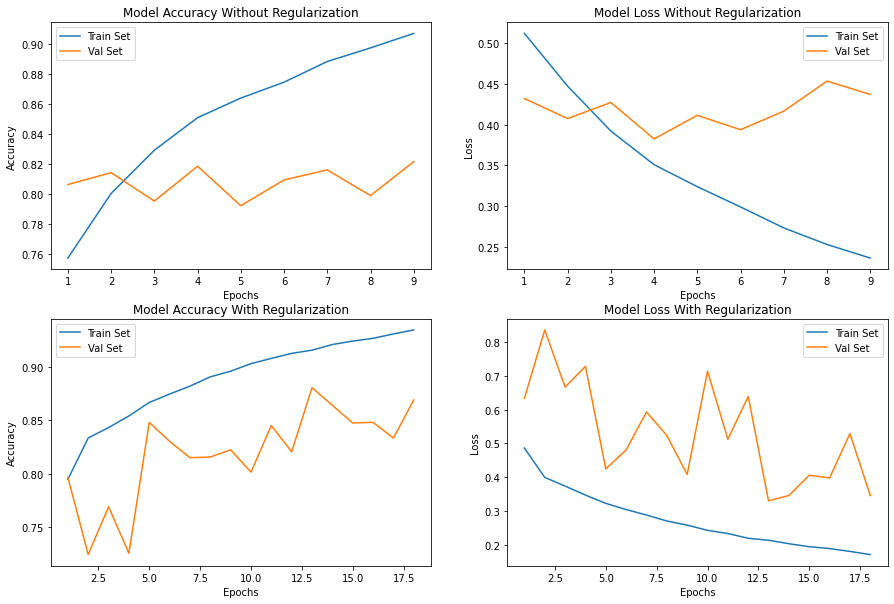

In [102]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accr = hist_reg.history['acc']
val_accr = hist_reg.history['val_acc']
lossr = hist_reg.history['loss']
val_lossr = hist_reg.history['val_loss']

er = range(1, len(hist.epoch) + 1)
err = range(1, len(hist_reg.epoch) + 1)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(er, acc, label='Train Set')
plt.plot(er, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Without Regularization')

plt.subplot(2, 2, 2)
plt.plot(er, loss, label='Train Set')
plt.plot(er, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Without Regularization')

plt.subplot(2, 2, 3)
plt.plot(err, accr, label='Train Set')
plt.plot(err, val_accr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy With Regularization')

plt.subplot(2, 2, 4)
plt.plot(err, lossr, label='Train Set')
plt.plot(err, val_lossr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss With Regularization')


    L2-Norm Regularization and Batch Normalization resulted in an increase in number of training epochs but reduced overfitting and improved the prediction of our model. We will use batch pooling before activation going forward. as it outperformed batch normalization after activation. (There has been a lot of research that also supported the fact that batch norm before activation is better)

# Tuning Optimizers

    Perhaps tuning the optimizers for the CNN will improve the performance of the model.

In [106]:
def train_model(optimizer):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

    model.compile(optimizer,
                  loss = "binary_crossentropy",
                  metrics=['acc'])

    hist_mod = model.fit(train_dataset,
              validation_data=validation_dataset,
              epochs = 50, 
              callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)])
    return hist_mod

In [107]:
adam = tf.keras.optimizers.Adam(0.0001)
adagrad = tf.keras.optimizers.Adagrad(0.0001)
rmsprop = tf.keras.optimizers.RMSprop(0.0001)
sgd = tf.keras.optimizers.SGD(0.0001)
opt_lst = [adam,adagrad,rmsprop,sgd]
hist_lst= []
for opt in opt_lst:
    hist = train_model(opt)
    hist_lst.append(hist)

Epoch 1/50
1639/1639 [==============================] - 53s 32ms/step - loss: 0.4746 - acc: 0.7975 - val_loss: 0.5635 - val_acc: 0.7436
Epoch 2/50
1639/1639 [==============================] - 52s 32ms/step - loss: 0.3973 - acc: 0.8322 - val_loss: 0.4710 - val_acc: 0.7601
Epoch 3/50
1639/1639 [==============================] - 52s 32ms/step - loss: 0.3717 - acc: 0.8452 - val_loss: 0.4017 - val_acc: 0.8242
Epoch 4/50
1639/1639 [==============================] - 52s 32ms/step - loss: 0.3482 - acc: 0.8544 - val_loss: 0.3931 - val_acc: 0.8370
Epoch 5/50
1639/1639 [==============================] - 52s 32ms/step - loss: 0.3282 - acc: 0.8646 - val_loss: 0.3965 - val_acc: 0.8449
Epoch 6/50
1639/1639 [==============================] - 52s 32ms/step - loss: 0.3069 - acc: 0.8737 - val_loss: 0.3743 - val_acc: 0.8303
Epoch 7/50
1639/1639 [==============================] - 52s 32ms/step - loss: 0.2906 - acc: 0.8815 - val_loss: 0.3885 - val_acc: 0.8205
Epoch 8/50
1639/1639 [==========================

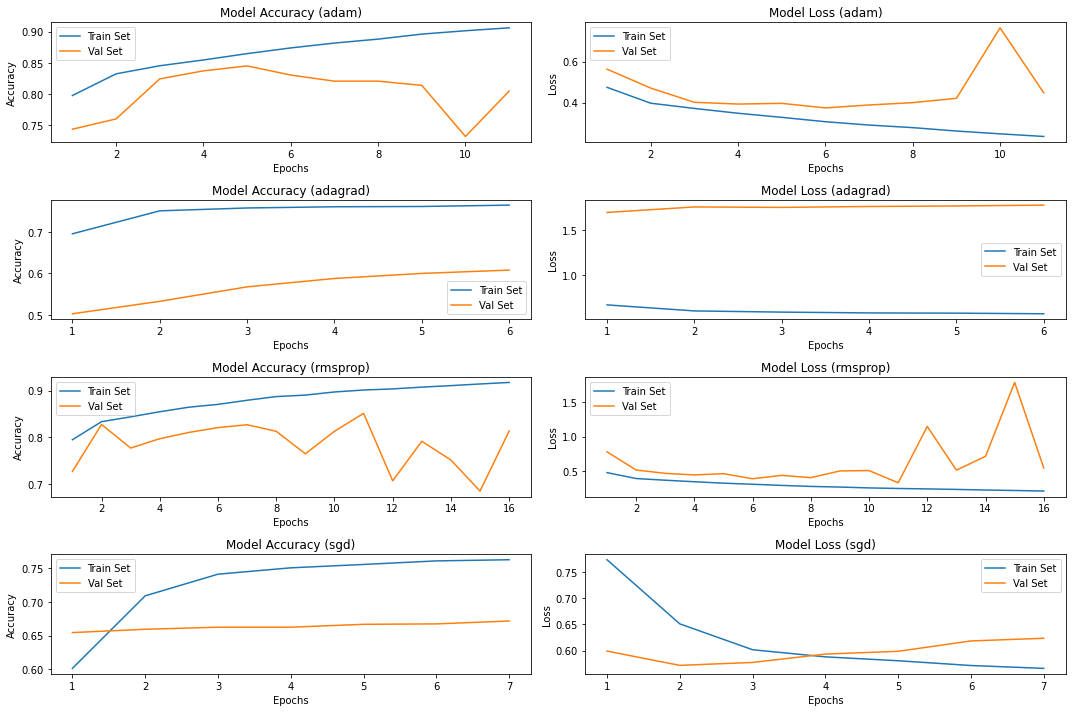

In [115]:
plt.figure(figsize=(15,10))
opt_lst_str = ['adam','adagrad','rmsprop','sgd']
for i in range(4):
    optimizer = opt_lst_str[i]
    hist = hist_lst[i]
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    er = range(1, len(hist.epoch) + 1)
    
    plt.subplot(4, 2, 2*i+1)
    plt.plot(er, acc, label='Train Set')

    plt.plot(er, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy ('+ optimizer+ ')')

    plt.subplot(4, 2, 2*i+2)
    plt.plot(er, loss, label='Train Set')
    plt.plot(er, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss ('+ optimizer+ ')')
plt.tight_layout()
plt.show()

    From initial observations, adam seems to be the best performing optimizer.

# Transfer Learning using VGG-16

     I'll be using VGG16 model which is pre-trained on the ImageNet dataset. We will experiment with retraining and without retraining the VGG16 conv layers.

In [39]:
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(96,96,3), classes = 2)

In [117]:
#Without Retraining
model = Sequential()
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.layers[0].trainable = False

model.summary()
model.compile(loss = 'binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['acc'])

hist_woret = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50,
          batch_size = 64,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_52 (Flatten)        (None, 4608)              0         
                                                                 
 dense_104 (Dense)           (None, 512)               2359808   
                                                                 
 dropout_136 (Dropout)       (None, 512)               0         
                                                                 
 dense_105 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 17,075,522
Trainable params: 2,360,834
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
1639/1639 [===========

In [118]:
#With Retraining
model = Sequential()
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()
model.compile(loss = 'binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['acc'])

hist_ret = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50,
          batch_size = 64,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_53 (Flatten)        (None, 4608)              0         
                                                                 
 dense_106 (Dense)           (None, 512)               2359808   
                                                                 
 dropout_137 (Dropout)       (None, 512)               0         
                                                                 
 dense_107 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 17,075,522
Trainable params: 2,360,834
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
1639/1639 [===========

Text(0.5, 1.0, 'Model Loss With Retraining')

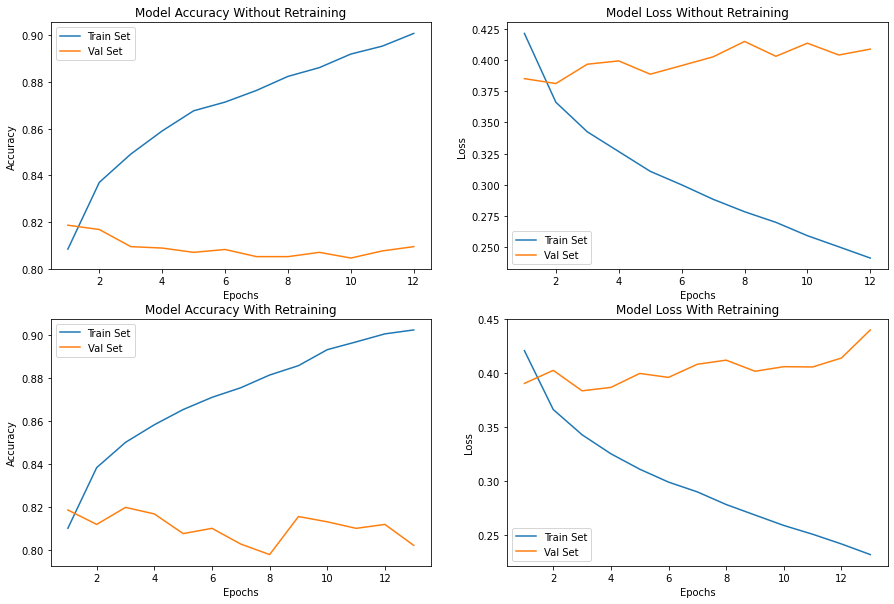

In [121]:
acc = hist_woret.history['acc']
val_acc = hist_woret.history['val_acc']
loss = hist_woret.history['loss']
val_loss = hist_woret.history['val_loss']

accr = hist_ret.history['acc']
val_accr = hist_ret.history['val_acc']
lossr = hist_ret.history['loss']
val_lossr = hist_ret.history['val_loss']

er = range(1, len(hist_woret.epoch) + 1)
err = range(1, len(hist_ret.epoch) + 1)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(er, acc, label='Train Set')
plt.plot(er, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Without Retraining')

plt.subplot(2, 2, 2)
plt.plot(er, loss, label='Train Set')
plt.plot(er, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Without Retraining')

plt.subplot(2, 2, 3)
plt.plot(err, accr, label='Train Set')
plt.plot(err, val_accr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy With Retraining')

plt.subplot(2, 2, 4)
plt.plot(err, lossr, label='Train Set')
plt.plot(err, val_lossr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss With Retraining')


# Data Augmentation

In [122]:
model = tf.keras.Sequential()
tf.get_logger().setLevel(logging.ERROR)
# data augmentation
model.add(tf.keras.layers.RandomRotation(0.2, input_shape = (96,96,3)))
model.add(tf.keras.layers.RandomFlip("horizontal"))

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))

model.compile(loss = 'binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['acc'])

hist_reg_da = model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs = 50, 
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1639/1639 [==============================] - 65s 39ms/step - loss: 0.4872 - acc: 0.7899 - val_loss: 0.9017 - val_acc: 0.6795
Epoch 2/50
1639/1639 [==============================] - 60s 37ms/step - loss: 0.3995 - acc: 0.8317 - val_loss: 0.7399 - val_acc: 0.7125
Epoch 3/50
1639/1639 [==============================] - 59s 36ms/step - loss: 0.3721 - acc: 0.8438 - val_loss: 0.5125 - val_acc: 0.8101
Epoch 4/50
1639/1639 [==============================] - 60s 37ms/step - loss: 0.3514 - acc: 0.8540 - val_loss: 0.4581 - val_acc: 0.8126
Epoch 5/50
1639/1639 [==============================] - 61s 37ms/step - loss: 0.3299 - acc: 0.8628 - val_loss: 0.4291 - val_acc: 0.8132
Epoch 6/50
1639/1639 [==============================] - 61s 37ms/step - loss: 0.3094 - acc: 0.8722 - val_loss: 0.3801 - val_acc: 0.8382
Epoch 7/50
1639/1639 [==============================] - 72s 44ms/step - loss: 0.2931 - acc: 0.8787 - val_loss: 0.3884 - val_acc: 0.8254
Epoch 8/50
1639/1639 [==========================

    Performance wise, this is comparable to without data augmentation. However, training accuracy is not as high as without data augmentation. (Lesser extent of overfitting)

# Conclusion

Best model: 6-layer nn with batch normalization before activation, and data augmentation.